# MESCAL 303: Interactive Geospatial `AreaKPIMapVisualizer` with Folium

This notebook demonstrates how to create interactive geospatial visualizations of electricity market data using the SegmentedColorMap module we explored in the previous notebook.

## Introduction

Geospatial visualization is one of the most effective ways to communicate regional patterns in electricity market data. In this notebook, we'll create a map showing:

1. Market prices by control area
2. Price increases between scenarios

We'll leverage our custom segmented colormaps to ensure clear visual differentiation between positive and negative values.

## Setup and Imports

In [1]:
import os
import numpy as np
import pandas as pd
import folium
from IPython.display import Image
import io
from PIL import Image as PILImage

from mescal import kpis
from mescal.units import Units
from mescal.visualizations.styling.segmented_colormap import SegmentedColorMapLegend
from mescal.utils.folium_utils.background_color import set_background_color_of_map
from mescal.visualizations.folium_map.kpi_map_visualizer_geometries import AreaKPIMapVisualizer

from mescal.utils.plotly_utils.plotly_theme import colors

# Directory setup
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
export_folder = 'studies/study_01_intro_to_mescal/non_versioned/output'
os.makedirs(export_folder, exist_ok=True)

from studies.study_01_intro_to_mescal.scripts.setup_study_manager import get_scigrid_de_study_manager

## Load Study Data

First, we load our study data which contains multiple scenarios of the German electricity system:


In [2]:
# Load the StudyManager with PyPSA Scigrid-DE network data we created in previous notebooks
study = get_scigrid_de_study_manager()

# Check available datasets
print("Available scenarios:")
for dataset in study.scen.datasets:
    print(f"- {dataset.name}")

INFO:pypsa.io:Imported network base.nc has buses, carriers, generators, lines, loads, storage_units, transformers
INFO:pypsa.io:Imported network solar_150.nc has buses, carriers, generators, lines, loads, storage_units, transformers
INFO:pypsa.io:Imported network solar_200.nc has buses, carriers, generators, lines, loads, storage_units, transformers
INFO:pypsa.io:Imported network wind_150.nc has buses, carriers, generators, lines, loads, storage_units, transformers
INFO:pypsa.io:Imported network wind_200.nc has buses, carriers, generators, lines, loads, storage_units, transformers


Available scenarios:
- base
- solar_150
- solar_200
- wind_150
- wind_200


## Adding KPIs to Scenarios and Comparisons

To create our visualizations, we need to calculate relevant KPIs for each scenario and for the comparisons between scenarios:

In [3]:
# Clear any existing KPIs
study.scen.clear_kpi_collection_for_all_sub_datasets()
study.comp.clear_kpi_collection_for_all_sub_datasets()

# Initialize KPI lists
my_scen_kpis = []
my_comp_kpis = []

# Get base dataset to access control areas
ds_base = study.scen.get_dataset('base')

# Create volume-weighted market price KPIs for each control area
scen_kpis_market_price = [
    kpis.FlagAggKPIFactory(
        'control_areas_t.vol_weighted_marginal_price',  # Time series flag
        aggregation=kpis.aggregations.Mean,            # Calculate mean across time
        column_subset=control_area                     # For each control area
    )
    for control_area in ds_base.fetch('control_areas').index.to_list()
]

# Add the price KPIs to our scenario KPIs list
my_scen_kpis += scen_kpis_market_price

# Create comparison KPIs to calculate price increases between scenarios
comp_vars_increase = [
    kpis.ComparisonKPIFactory(
        factory,                         # Use the same KPI factories as scenarios
        kpis.value_comparisons.Increase  # Calculate simple increase (var - ref)
    )
    for factory in my_scen_kpis
]

# Add the comparison KPIs to our comparison KPIs list
my_comp_kpis += comp_vars_increase

# Add all KPIs to respective datasets
study.scen.add_kpis_to_all_sub_datasets(my_scen_kpis)
study.comp.add_kpis_to_all_sub_datasets(my_comp_kpis)

# Compute all KPIs (with progress bar)
study.scen.get_merged_kpi_collection().compute_all(pbar=True)
study.comp.get_merged_kpi_collection().compute_all(pbar=True)

Computing KPIs KPICollection for dataset_type unit flag aggregation base_unit model_flag: 100%|██████████| 20/20 [00:00<00:00, 34.75it/s]
Computing KPIs KPICollection for unit flag aggregation base_unit model_flag: 100%|██████████| 36/36 [00:01<00:00, 27.21it/s]


## Setting up the Map

Now we'll create a basic Folium map centered on Germany:

In [4]:
# Create a map centered on Germany
m = folium.Map(
    location=[51, 11],  # Center of Germany
    tiles=None,         # No background tiles initially
    zoom_start=6,       # Initial zoom level
    zoom_snap=0.25      # Allow finer zoom control
)

# Set a clean white background
m = set_background_color_of_map(m, color='#ffffff')

## Visualizing Market Prices by Control Area

Using our custom segmented colormap from the previous notebook, we'll create a visualization of market prices across Germany's control areas:

In [5]:
# Define the market price colormap legend (same as in mescal_302)
price_segments = {
    (-500, -25): ['#000080'],               # Navy for extreme negative prices
    (-25, 0): ['#0000FF', '#87CEFA'],       # Blue to light blue for negative prices
    (0, 25): ['#00C300', '#FFFB00'],        # Light green to yellow for low positive prices
    (25, 500): ['#FFFB00', '#FF9300'],      # Yellow to orange for high positive prices
    (500, 10000): ['#FF0000']                # Red for extreme positive prices
}

# Create the legend
price_legend = SegmentedColorMapLegend(
    segments=price_segments,
    title="Market Price (€/MWh)",
    width=350,
    bar_height=25,
    total_height=55,
    padding=20,
    background_color="#FFFFFF",
    n_ticks_per_segment=2,
    position={'bottom': 20, 'right': 20}
)

# Create area KPI visualizer with the colormap
visualizer = AreaKPIMapVisualizer(
    study,
    price_legend,
    widthmap=1.5,  # Fixed line width
    opacitymap=1,  # Fixed opacity
    include_related_kpis_in_tooltip=False
)

# Get KPI collection for scenarios
kpi_collection = study.scen.get_merged_kpi_collection()

# Generate feature groups for the map
fgs = visualizer.get_feature_groups(kpi_collection)
for fg in fgs:
    m.add_child(fg)
    
# Add the colormap legend to the map
m.add_child(price_legend);

AreaKPIMapVisualizer: 100%|██████████| 20/20 [00:00<00:00, 641.14it/s]


## Visualizing Price Increases Between Scenarios

Next, we'll add another layer showing the price differences between scenarios:

In [6]:
# Define a new colormap for price increases
colormap_price_increase = SegmentedColorMapLegend(
    segments={
        (0, 10): colors.sequential.shades_of_pink,    # Pink for price increases
        (-10, 0): colors.sequential.shades_of_cyan[::-1],  # Cyan for price decreases
    },
    na_color='#A2A2A2',  # Gray for NA values
    title='Price Increase (Vol Weighted) [€/MWh]',
    background_color='white',
    width=350,
    total_height=35,
    position=dict(bottom=150, right=20),  # Position below the first legend
    padding=20,
    n_ticks_per_segment=2,
)

# Create a new visualizer for comparison data
visualizer = AreaKPIMapVisualizer(
    study,
    colormap_price_increase,
    widthmap=1.5,
    opacitymap=1.0,
    include_related_kpis_in_tooltip=False
)

# Filter KPI collection to include only "Increase" values
kpi_collection = study.comp.get_merged_kpi_collection().get_filtered_kpi_collection_by_attributes(
    value_operation='Increase'
)

# Generate feature groups for comparisons
fgs = visualizer.get_feature_groups(kpi_collection)
for fg in fgs:
    if fg == fgs[-1]:
        fg.show = True
    m.add_child(fg)
    
# Add the second colormap legend to the map
m.add_child(colormap_price_increase);

AreaKPIMapVisualizer: 100%|██████████| 16/16 [00:00<00:00, 250.31it/s]


## Adding Layer Controls and Finalizing the Map

Finally, we'll add layer controls so users can toggle between different visualizations:

In [7]:
# Add layer controls
folium.LayerControl(collapsed=False, draggable=True).add_to(m);

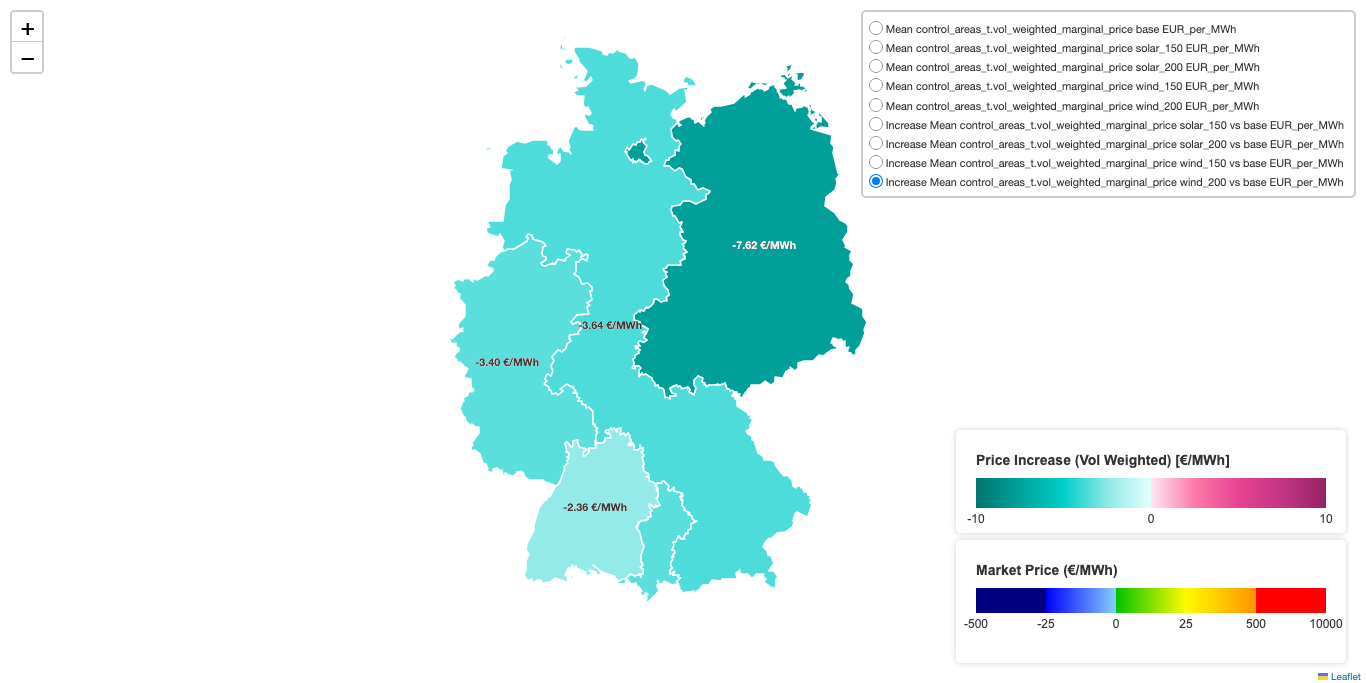

In [8]:
# Save map as static image and display the image inside this notebook
image_path = os.path.join(export_folder, 'map_de_prices.png')
img_data = m._to_png(5)  # 5 second delay to ensure everything renders
img = PILImage.open(io.BytesIO(img_data))
img.save(image_path)
Image(image_path)

# Use this instead when you are running locally and want to view the interactive html inside the notebook
# m

# Use this instead when you want to save the map as an html and want to open it in your browser
# html_file_path = os.path.join(export_folder, 'map_de_prices.html')
# m.save(html_file_path)
# import webbrowser
# from pathlib import Path
# webbrowser.open(Path(html_file_path).resolve().as_uri());

## What do we see?
If you are watching the static image in the Jupyter Notebook, it is showing the "Price Increase" for the last scenario-comparison in the study (wind_200 vs base).
Since all values are negative, we know that the increase to 200% wind lead to a price decrease in all control_areas, with the highest price reduction in 50Hertz control_area (North-East), and the smallest reduction in the EnBW control area (South-West).

If you open the interactive version (either through showing m in the notebook, or by saving the map as an html and opening it in the browser), you can select the FeatureGroup in the map's menu on the top right and select the dataset (comparison) and indicator you want to project on the map. Besides projecting the "Price Increase" for each scenario-comparison, you can also show the "Market Price" per single scenario.

## Conclusion

In this notebook, we've demonstrated how to create advanced geospatial visualizations of electricity market data using Folium and our custom SegmentedColorMap module. The key advantages of this approach are:

1. **Clear visual differentiation** between positive and negative values
2. **Multiple map layers** for different types of analysis (absolute prices and price changes)
3. **Custom legends** that help interpret the data
4. **Interactive features** like hover tooltips and layer toggling

These techniques can be applied to any geospatial electricity market data, allowing for intuitive visualization of complex market dynamics across regions.

In the next notebook, we'll explore how to create animated visualizations to show temporal patterns in market data.